# SmartSifter

## ライブラリのインポート

In [1]:
import os
import numpy as np
import numpy.random  as rd
from scipy import stats as st
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("ggplot")
%matplotlib inline

In [2]:
os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from smartsifter import SmartSifter
os.chdir(home_dir)

## データの生成

In [3]:
seed = 0
#データ生成(離散値ベクトル)
rd.seed(seed)
T = 500 #データ数(観測数)
# x_1 = np.array([np.argmax(i) for i in rd.multinomial(1, [1/6]*6,T)])
# x_2 = rd.binomial(1, 0.5, T)
x_1 = np.array([np.argmax(i) for i in rd.multinomial(1, [1]*1,T)])
x = x_1.copy()
# x = np.c_[x_1, x_2]

#データ生成(連続変数ベクトル)
n = [200, 150, 150] #各データ数
K = 3 #潜在変数の数
D = 2 #次元

#mu:D次元
mu_true = np.array(
    [[0.2, 0.5],
     [1.2, 0.5],
     [2.0, 0.5]])

#sigma: D×D次元
sigma_true = np.array(
    [[[0.1,  0.085], [0.085, 0.1]],
     [[0.1, -0.085], [-0.085, 0.1]],
     [[0.1,  0.085], [0.085, 0.1]]
    ])

rd.seed(seed)
org_data = None
for i in range(K):
    #k_0 に属するデータを生成
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        
    #k_1, k_2に属するデータを生成し、結合する
    else:
        tmp_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        org_data = np.r_[org_data, tmp_data]

#print(org_data)
y = org_data[:, :2]

## パラメータの設定

In [4]:
#パラメータの設定
#SDLE
A = list(itertools.product(set(x)))
# A = list(itertools.product(set(x_1), set(x_2)))
beta = 1 #正の定数

#SDEM
alpha = 1.0 #(1.0~2.0)
r = 1 / T * 5
k = K #潜在変数の数
d = D #次元
#SmartSifter
r_h = 0.1

## SmartSifterの実行

In [5]:
ss = SmartSifter(r, beta, A, alpha, k, r_h)
ss.train(x, y) 

/Users/satetsu/program/python/datamining/anomaly_detection_with_data_mining/src/smartsifter.py:116: RuntimeWarning: divide by zero encountered in log
  s_l = -np.log(p_prev_params) #シャノン情報量を計算


In [6]:
# 入力データと計算結果(対数損失)を表示
#for ix, iy, S_L in zip(x, y, ss.S_L):
#    print(ix, iy, S_L)

## 日経平均株価にSmartSifterを適用(前日との変動)

## データの読み込み

In [7]:
df = pd.read_csv("data/nikkei225_d.csv")
display(df.head())

,Date,Open,High,Low,Close
0,1986/01/04,13118.50,13142.33,13105.97,13136.87
1,1986/01/06,13129.05,13145.54,13053.22,13053.79
2,1986/01/07,13034.57,13037.68,12933.50,12991.24
3,1986/01/08,12997.74,13057.46,12996.80,13056.42
4,1986/01/09,13036.08,13062.26,12959.21,13034.19


## データの加工

In [8]:
df.Date = [i.replace("/", "-")for i in df.Date]
df["Date"] = pd.DatetimeIndex(df["Date"])
df["day_of_week"] = df.Date.dt.dayofweek
dataset = df.iloc[:, 1:]
# 前日からの変化
dataset = dataset.diff().iloc[1:, :-1]

In [9]:
# データの正規化
dataset = (dataset - dataset.min())/(dataset.max() - dataset.min())
display(dataset.describe())

,Open,High,Low,Close
count,7712.000000,7712.000000,7712.000000,7712.000000
mean,0.588692,0.496378,0.612794,0.589166
std,0.035469,0.054543,0.037211,0.037210
min,0.000000,0.000000,0.000000,0.000000
25%,0.571219,0.468691,0.596479,0.571542
50%,0.589235,0.496398,0.614487,0.589993
75%,0.607164,0.524974,0.631823,0.608358
max,1.000000,1.000000,1.000000,1.000000


In [10]:
# x
# 全て0
#x = np.array([0 for i in range(dataset.shape[0])], dtype=np.int64)
# 曜日ごと
x = np.array(df.day_of_week[1:])

# y
# [始値, 高値, 安値, 終値]のデータ
#y = np.array(dataset)
# [始値, 終値]のデータ
y = np.concatenate([dataset.Open[:, np.newaxis], dataset.Close[:, np.newaxis]], axis=1)
# [終値]のデータ
#y = dataset.Close[:, np.newaxis]

## パラメータの設定

In [11]:
#SDLE
A = list(itertools.product(set(x))) # xの有限分割
beta = 1 #正の定数
#SDEM
alpha = 1.0 #(1.0~2.0)
r = 0.02 # 忘却係数 (0<r<1)
k = K # 混合数
#SmartSifter
r_h = 0.1

## SmartSifterの実行

In [12]:
ss = SmartSifter(r, beta, A, alpha, k, r_h)
ss.train(x, y) 

/Users/satetsu/program/python/datamining/anomaly_detection_with_data_mining/src/smartsifter.py:116: RuntimeWarning: divide by zero encountered in log
  s_l = -np.log(p_prev_params) #シャノン情報量を計算


In [13]:
dataset["S_L"] = np.array(ss.S_L)
dataset["S_H"] = np.array(ss.S_H)
dataset.describe()

,Open,High,Low,Close,S_L,S_H
count,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.0
mean,0.588692,0.496378,0.612794,0.589166,inf,0.0
std,0.035469,0.054543,0.037211,0.037210,NaN,0.0
min,0.000000,0.000000,0.000000,0.000000,2.038610,0.0
25%,0.571219,0.468691,0.596479,0.571542,3.389861,0.0
50%,0.589235,0.496398,0.614487,0.589993,4.044490,0.0
75%,0.607164,0.524974,0.631823,0.608358,5.190552,0.0
max,1.000000,1.000000,1.000000,1.000000,inf,0.0


## 可視化

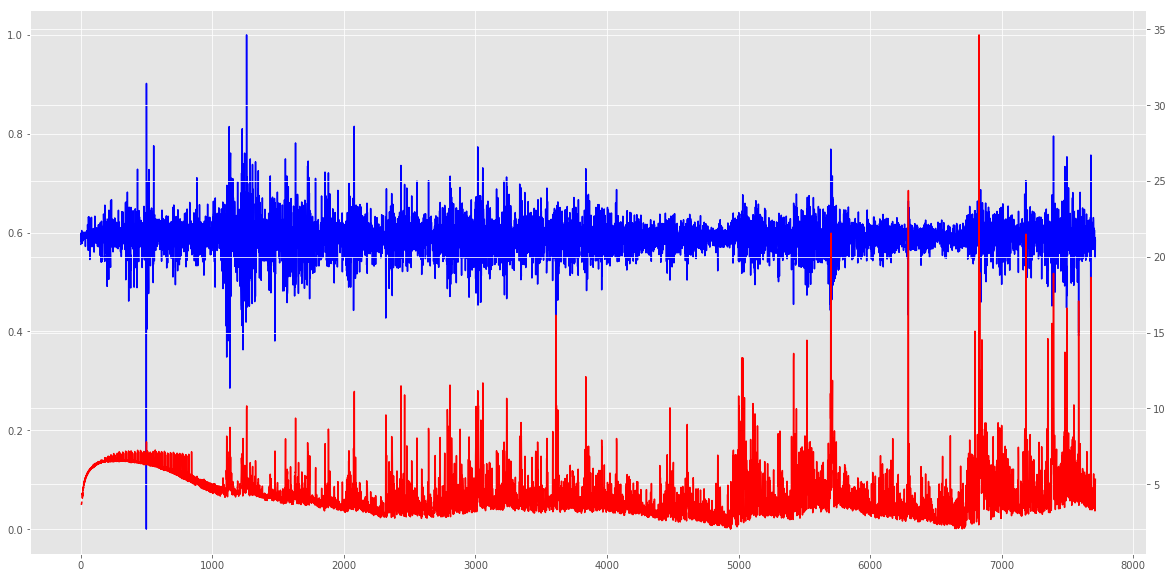

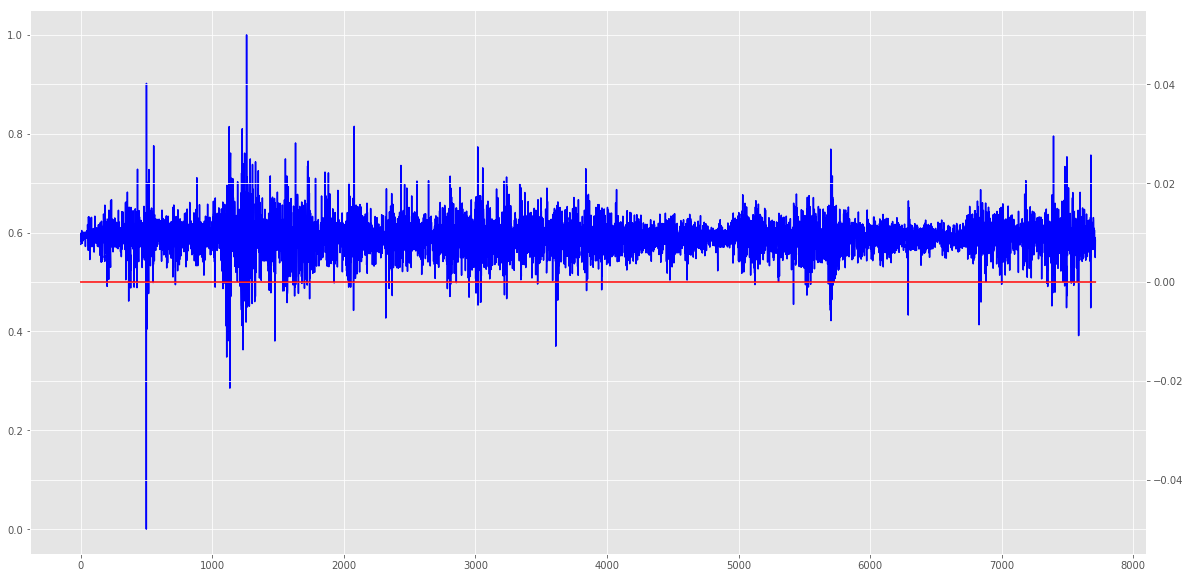

In [14]:
# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(dataset.Close, c="b")
ax2 = ax.twinx()
ax2.plot(dataset.S_L,'r')
plt.show()

# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(dataset.Close, c="b")
ax2 = ax.twinx()
ax2.plot(dataset.S_H,'r')
plt.show()

## 日経平均株価にSmartSifterを適用(価格そのもの)

## データの読み込み

In [15]:
df = pd.read_csv("data/nikkei225_d.csv")
df.Date = [i.replace("/", "-")for i in df.Date]
df["Date"] = pd.DatetimeIndex(df["Date"])
df["day_of_week"] = df.Date.dt.dayofweek
df.iloc[:, 1:-1] = (df.iloc[:, 1:-1]-df.iloc[:, 1:-1].min())/(df.iloc[:, 1:-1].max() - df.iloc[:, 1:-1].min())
df.head()

,Date,Open,High,Low,Close,day_of_week
0,1986-01-04,0.190156,0.189648,0.191974,0.190889,5
1,1986-01-06,0.190487,0.189749,0.190317,0.188281,0
2,1986-01-07,0.187522,0.186363,0.186556,0.186318,1
3,1986-01-08,0.186366,0.186984,0.188544,0.188364,2
4,1986-01-09,0.187569,0.187135,0.187364,0.187666,3


In [16]:
# 全て0
#x = np.array([0 for i in range(df.shape[0])], dtype=np.int64)
# 曜日ごと
x = np.array(df.day_of_week)
# [始値, 高値, 安値, 終値]のデータ
y = np.array(df.iloc[:, 1:-1])
# [始値, 終値]のデータ
#y = np.concatenate([df.Open[:, np.newaxis], df.Close[:, np.newaxis]], axis=1)
# [終値]のデータ
#y = df.Close[:, np.newaxis]

## パラメータの設定

In [17]:
#パラメータの設定
#SDLE
A = list(itertools.product(set(x))) # xの有限分割
r = 1 / len(x) #忘却パラメータ
beta = 1 #正の定数

#SDEM
alpha = 1.0 #(1.0~2.0)
r = 0.02
k = K # 混合数
#SmartSifter
r_h = 0.1

## SmartSifterの実行

In [18]:
ss = SmartSifter(r, beta, A, alpha, k, r_h)
ss.train(x, y) 

/Users/satetsu/program/python/datamining/anomaly_detection_with_data_mining/src/smartsifter.py:116: RuntimeWarning: divide by zero encountered in log
  s_l = -np.log(p_prev_params) #シャノン情報量を計算


In [19]:
df["S_L"] = np.array(ss.S_L)
df["S_H"] = np.array(ss.S_H)
df.describe()

,Open,High,Low,Close,day_of_week,S_L,S_H
count,7713.000000,7713.000000,7713.000000,7713.000000,7713.000000,7713.000000,7713.0
mean,0.308426,0.310853,0.306841,0.308457,2.061195,inf,0.0
std,0.196414,0.197309,0.195625,0.196403,1.432575,NaN,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,-11.449926,0.0
25%,0.141807,0.142905,0.141844,0.142001,1.000000,-7.551285,0.0
50%,0.295164,0.298193,0.293297,0.295244,2.000000,-5.892966,0.0
75%,0.403998,0.406550,0.403011,0.403941,3.000000,-1.126657,0.0
max,1.000000,1.000000,1.000000,1.000000,5.000000,inf,0.0


## 可視化

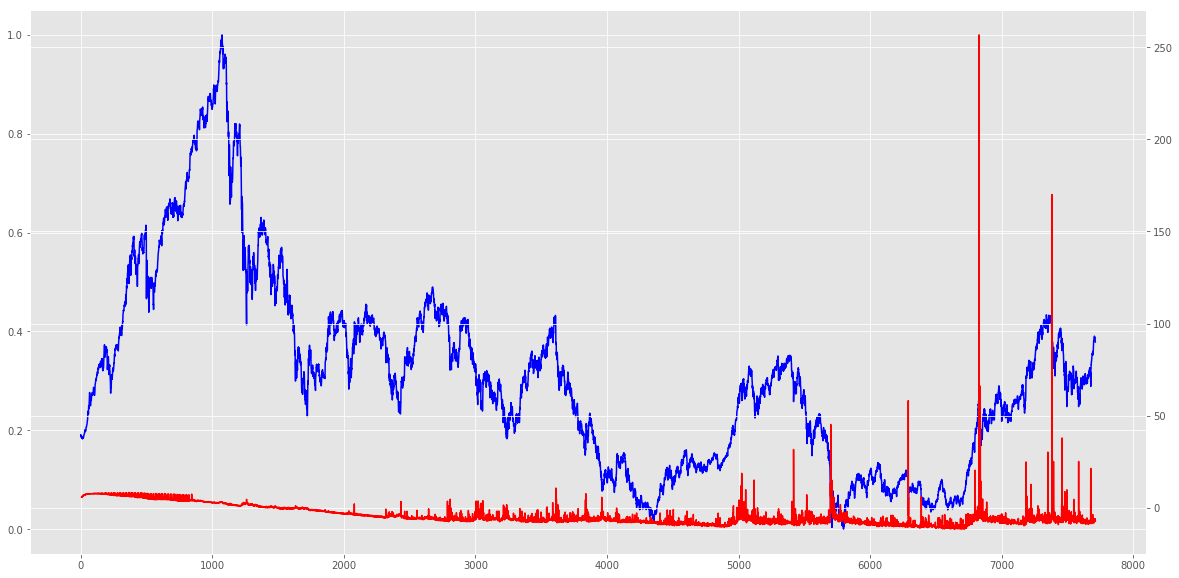

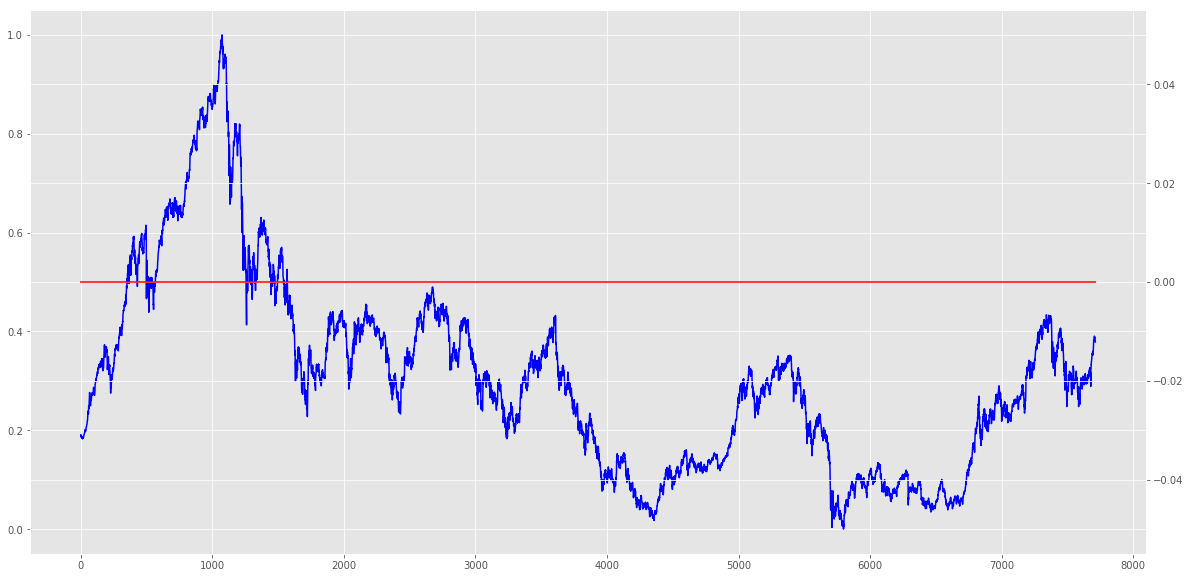

In [20]:
# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df.Close, c="b")
ax2 = ax.twinx()
ax2.plot(df.S_L,'r')
plt.show()

# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df.Close, c="b")
ax2 = ax.twinx()
ax2.plot(df.S_H,'r')
plt.show()